# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

from importlib import reload
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Load Data

We recommend the use of scanpy Anndata objects as the preferred mode of loading and filtering data.

A sample dataset is provided and can be accessed using the ```load_data()``` method

In [3]:
from SEACells.utils import load_data

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
ad = load_data()

# Pre-processing

The following section describes basic pre-processing steps for scRNA-seq. For scATAC-seq, we provide a pipeline for pre-processing in  in example notebook `preprocessing-ATAC.ipynb`

In [5]:
# First we remove any genes which have counts for fewer than 5 cells
non_zero_entries =  np.count_nonzero(ad.to_df(), axis=0)
keep_genes = ad.var_names[non_zero_entries>=5]
ad = ad[:, keep_genes]

# We drop any cells with zero expression as well
keep_cells = ad.obs_names[ad.to_df().sum(1) > 0]
ad = ad[keep_cells, :]

In [6]:
# We now generate principal components, which will be later used to run Metacells.
# 

# Normalize cells and compute highly variable genes
sc.pp.normalize_per_cell(ad)
sc.pp.highly_variable_genes(ad)

# Compute principal components - 
# Here we use 50 components. This number may also be selected by examining variance explaint
sc.tl.pca(ad, n_comps=50, use_highly_variable=True)

Trying to set attribute `.obs` of view, copying.


# Running SEACells

In [7]:
## User defined parameters

## Core parameters 
n_SEACells = 10
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
waypoint_proportion = 1 # Proportion of metacells to initialize using waypoint analysis, 
                        # the remainder of cells are selected by greedy selection




In [8]:
from SEACells.core import SEACells


model = SEACells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

model.fit(n_iter=100)


Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...



Making graph symmetric...
Computing RBF kernel...



Building similarity LIL matrix...



Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 9 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...



Selecting 1 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.004641388313302565
Starting iteration 1.
Completed iteration 1.
Contains 10 SEACells after 1 iterations.
Contains 10 SEACells after 2 iterations.
Contains 10 SEACells after 3 iterations.
Contains 10 SEACells after 4 iterations.
Contains 10 SEACells after 5 iterations.
Contains 10 SEACells after 6 iterations.
Contains 10 SEACells after 7 iterations.
Contains 10 SEACells after 8 iterations.
Contains 10 SEACells after 9 iterations.
Starting iteration 10.
Completed iteration 10.
Contains 10 SEACells after 10 iterations.
Contains 10 SEACells after 11 iterations.
Contains 10 SEACells after 12 iterations.
Contains 10 SEACells after 13 iterations.
Contains 10 SEACells after 14 iterations.
Contains 10 SEACells after 15 iterations.
Contains 10 SEACells after 16 iterations.
Contains 10 SEACells after 17 iterations.
Contains 10 SEACells after 18 iterations.
Contains 10 SEACells after 19

# Accessing results

### Model Parameters

The SEACells model oject has the following attributes

### Model Convergence

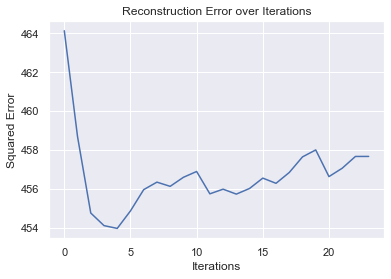

In [9]:
%matplotlib inline
# Check for convergence 
model.plot_convergence()

### SEACell Assignments

These can be accessed as folows:
- in the modified anndata object in `.obs['SEAell']`
- from the model using `.get_assignments()`


In [10]:
ad.obs[['SEACell']].head()

,SEACell
index,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep1#ACAGGAATCCACCTTA-1
cd34_multiome_rep1#AAACAGCCACTGACCG-1,cd34_multiome_rep1#AAAGCGGGTATTCGCT-1
cd34_multiome_rep1#AAACAGCCATAATCAC-1,cd34_multiome_rep1#ACAGGAATCCACCTTA-1
cd34_multiome_rep1#AAACATGCAAATTCGT-1,cd34_multiome_rep1#ACAGGAATCCACCTTA-1
cd34_multiome_rep1#AAACATGCAGCATGTC-1,cd34_multiome_rep1#AATGAAGGTAGCTGGT-1


In [11]:
model.get_assignments().head()

,SEACell
index,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep1#ACAGGAATCCACCTTA-1
cd34_multiome_rep1#AAACAGCCACTGACCG-1,cd34_multiome_rep1#AAAGCGGGTATTCGCT-1
cd34_multiome_rep1#AAACAGCCATAATCAC-1,cd34_multiome_rep1#ACAGGAATCCACCTTA-1
cd34_multiome_rep1#AAACATGCAAATTCGT-1,cd34_multiome_rep1#ACAGGAATCCACCTTA-1
cd34_multiome_rep1#AAACATGCAGCATGTC-1,cd34_multiome_rep1#AATGAAGGTAGCTGGT-1


# Summarizing data

- `.summarize_by_SEACell()`

Datasets can be summarized by SEACell by aggregating cells within each SEACell, summing over all raw data for all cells belonging to a SEACell. The output of this function is an anndata object of shape n_metacells x original_data_dimension. Data is unnormalized and raw aggregated counts are stored .layers['raw']. Attributes associated with variables (.var) are copied over, but relevant per SEACell attributes must be manually copied, since certain attributes may need to be summed, or averaged etc, depending on the attribute.



In [12]:
SEACell_ad = model.summarize_by_SEACell()
SEACell_ad

KeyError: 'raw'

# Evaluating Results

We provide several methods for evaluating SEACell assignments:

## 1.Visualizing Results

Metacells also implements methods for visualizing the results of the Metacells algorithm 
    <ul> 
        <li>```.plot_2D()``` provides an interface for viewing metacell assignments on any 2-dimensional embedding in ad.obsm. Plots can also be coloured by metacell assignment.
        <li>```.plot_SEACell_sizes()``` can be used to view the distribution of number of cells assigned to each metacell
    </ul>
    
            

In [13]:
# Load the plotting functions as plot
from SEACells import plot
sns.set(style="white")

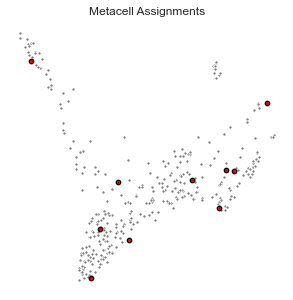

In [14]:
plot.plot_2D(ad, key='X_FDL', colour_metacells=False)

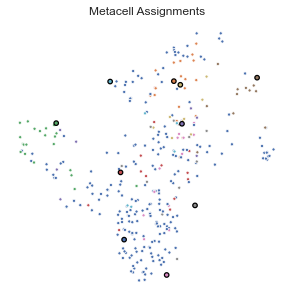

In [15]:
plot.plot_2D(ad, key = 'X_umap', colour_metacells=True)

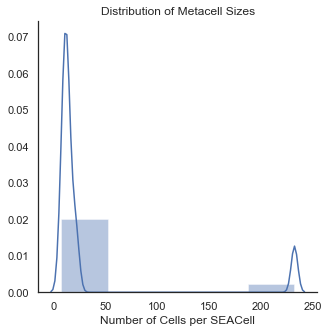

,size
SEACell,
cd34_multiome_rep1#AAAGCGGGTATTCGCT-1,18
cd34_multiome_rep1#AAGCGTTTCACGAATC-1,10
cd34_multiome_rep1#AAGTTACGTCATGAGC-1,7
cd34_multiome_rep1#AAGTTAGCACCTATAG-1,13
cd34_multiome_rep1#AATGAAGGTAGCTGGT-1,22
cd34_multiome_rep1#ACAACAGAGTATCGCG-1,10
cd34_multiome_rep1#ACAGGAATCCACCTTA-1,232
cd34_multiome_rep1#ACAGGAATCCAGCACA-1,14
cd34_multiome_rep1#ACATAGCTCATTATGG-1,12


In [16]:
plot.plot_SEACell_sizes(ad, bins=5)

## 2. Quantifying Results

Metacells also implements methods for visualizing the results of the Metacells algorithm 
    <ul> 
        <li>```.compute_celltype_purity(ad, col_name)``` computes the purity of different celltype labels within a SEACell metacell. Typically, col_name='celltype' or similar. Returns a pd.DataFrame of length n_SEACells.
        <li>```.diffusion_component_variance(ad, low_dim_embedding)``` computes the per-SEAcell variance in diffusion components. ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. Lower values of compactness suggest more compact/lower variance metacells.
        <li>```diffusion_component_dist_to_NN(ad, low_dim_embedding,nth_nbr=1,cluster=None)``` computes the diffusion distance between a SEACell and its ```nth_nbr```. As before, ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. If ```cluster``` is provided as a string, e.g. 'celltype', nearest neighbors are restricted to have the same celltype value.  Higher values of separation suggest better distinction between metacells.
    </ul>
    


In [17]:
from SEACells import evaluate

sns.set(style='white')
%matplotlib inline

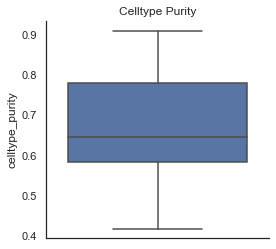

,celltype,celltype_purity
SEACell,,
cd34_multiome_rep1#AAAGCGGGTATTCGCT-1,Mono,0.888889
cd34_multiome_rep1#AAGCGTTTCACGAATC-1,HMP,0.800000
cd34_multiome_rep1#AAGTTACGTCATGAGC-1,HMP,0.428571
cd34_multiome_rep1#AAGTTAGCACCTATAG-1,HMP,0.692308
cd34_multiome_rep1#AATGAAGGTAGCTGGT-1,Ery,0.909091


In [18]:
SEACell_purity = evaluate.compute_celltype_purity(ad, 'celltype')

plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='celltype_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

Determing nearest neighbor graph...


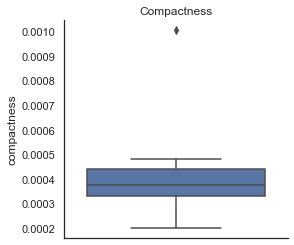

,compactness
SEACell,
cd34_multiome_rep1#AAAGCGGGTATTCGCT-1,0.000381
cd34_multiome_rep1#AAGCGTTTCACGAATC-1,0.000273
cd34_multiome_rep1#AAGTTACGTCATGAGC-1,0.000364
cd34_multiome_rep1#AAGTTAGCACCTATAG-1,0.000404
cd34_multiome_rep1#AATGAAGGTAGCTGGT-1,0.000322


In [19]:
compactness = evaluate.diffusion_component_variance(ad, 'X_pca')

plt.figure(figsize=(4,4))
sns.boxplot(data=compactness, y='compactness')
plt.title('Compactness')
sns.despine()
plt.show()
plt.close()

compactness.head()

Determing nearest neighbor graph...


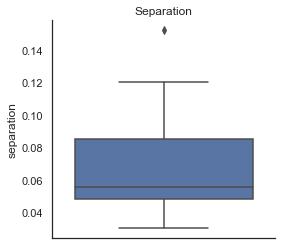

,separation
SEACell,
cd34_multiome_rep1#AAAGCGGGTATTCGCT-1,0.093124
cd34_multiome_rep1#AAGCGTTTCACGAATC-1,0.051011
cd34_multiome_rep1#AAGTTACGTCATGAGC-1,0.060509
cd34_multiome_rep1#AAGTTAGCACCTATAG-1,0.060763
cd34_multiome_rep1#AATGAAGGTAGCTGGT-1,0.152045


In [20]:
separation = evaluate.diffusion_component_dist_to_NN(ad, 'X_pca',nth_nbr=1)

plt.figure(figsize=(4,4))
sns.boxplot(data=separation, y='separation')
plt.title('Separation')
sns.despine()
plt.show()
plt.close()

separation.head()